In [19]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = 'chinook.db'

In [2]:
def run_query(q):
    with sqlite3.connect(db) as connection:
        return pd.read_sql(q, connection)

In [3]:
def run_command(c):
    with sqlite3.connect(db) as connection:
        connection.isolation_level = None
        connection.execute(c)

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
q = '''
SELECT * FROM customer
'''
run_query(q)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4
5,6,Helena,Holý,None,Rilská 3174/6,Prague,None,Czech Republic,14300,+420 2 4177 0449,None,hholy@gmail.com,5
6,7,Astrid,Gruber,None,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,+43 01 5134505,None,astrid.gruber@apple.at,5
7,8,Daan,Peeters,None,Grétrystraat 63,Brussels,None,Belgium,1000,+32 02 219 03 03,None,daan_peeters@apple.be,4
8,9,Kara,Nielsen,None,Sønder Boulevard 51,Copenhagen,None,Denmark,1720,+453 3331 9991,None,kara.nielsen@jubii.dk,4
9,10,Eduardo,Martins,Woodstock Discos,"Rua Dr. Falcão Filho, 155",São Paulo,SP,Brazil,01007-010,+55 (11) 3033-5446,+55 (11) 3033-4564,eduardo@woodstock.com.br,4


In [7]:
genres_sold_in_US = '''
WITH tracks_sold_in_US AS (
    SELECT il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country LIKE 'USA'
)

SELECT
    g.name genre,
    count(tsiU.invoice_line_id) tracks_sold,
    cast(count(tsiU.invoice_line_id) as FLOAT) / (
        SELECT count(*) FROM tracks_sold_in_US
    ) percentage_sold
FROM tracks_sold_in_US tsiU
INNER JOIN track t ON tsiU.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(genres_sold_in_US)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


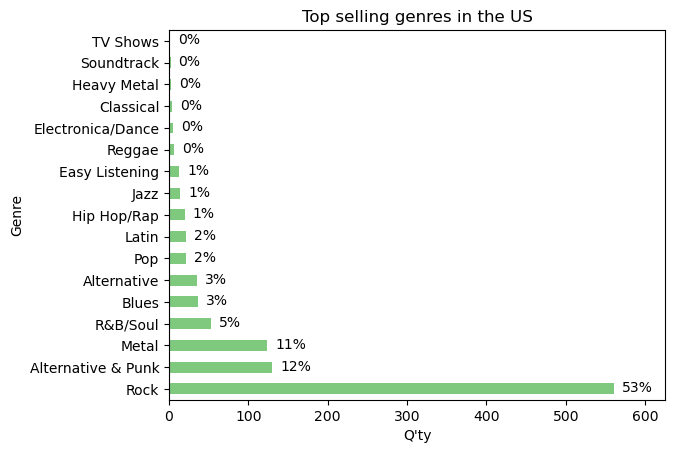

In [8]:
genres_sales_usa = run_query(genres_sold_in_US)
genres_sales_usa.set_index("genre", inplace=True, drop=True)
genres_sales_usa['tracks_sold'].plot.barh(
    title='Top selling genres in the US',
    xlim=(0, 625),
    colormap=plt.cm.Accent
)
plt.ylabel('Genre')
plt.xlabel("Q'ty")
for i, label in enumerate(list(genres_sales_usa.index)):
    score = genres_sales_usa.loc[label, 'tracks_sold']
    label = (genres_sales_usa.loc[label, 'percentage_sold'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that, combined, these three genres only make up 17% of total sales, so we should watch for artists and albums from the "rock" genre, which accounts for 53% of sales.

In [9]:
sale_perf = '''
WITH customer_paid as (
    SELECT 
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i 
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
)

SELECT
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    SUM(cp.total) total_sales
FROM employee e 
INNER JOIN customer_paid cp ON e.employee_id = cp.support_rep_id
GROUP BY 1
ORDER BY total_sales DESC ;
'''

run_query(sale_perf)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


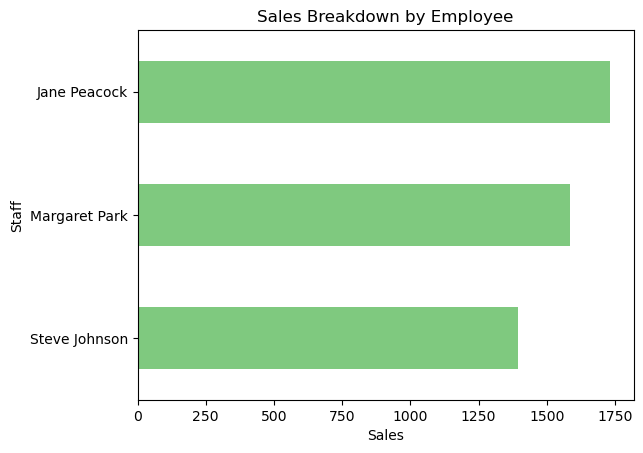

In [10]:
employee_perf = run_query(sale_perf)
employee_perf.set_index("employee", inplace=True, drop=True)
employee_perf.sort_values('total_sales', inplace=True)
employee_perf.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('Staff')
plt.xlabel("Sales")
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference approximately corresponds to the differences in their hiring dates.

In [16]:
countries_and_others = '''
WITH customer_contries_invoice as (
    SELECT 
        CASE 
            WHEN (
                SELECT count(*)
                FROM customer
                WHERE country = c.country
            ) = 1 then 'Other'
            ELSE c.country
        END AS country,
        c.customer_id,
        i.total,
        i.invoice_id
    FROM invoice i 
    INNER JOIN customer c ON i.customer_id = c.customer_id
)

SELECT 
    country,
    customers,
    total_sales,
    avg_per_order,
    avg_per_customer
FROM (
    SELECT
        country,
        count(distinct customer_id) as customers,
        sum(total) as total_sales,
        cast(sum(total) as FLOAT)/count(distinct customer_id) as avg_per_customer,
        cast(sum(total) as FLOAT)/count(distinct invoice_id) as avg_per_order,
        CASE 
            WHEN country = 'Other' THEN 1
            ELSE 0
        END as sort
    FROM customer_contries_invoice
    GROUP BY 1
    ORDER BY sort ASC, total_sales DESC
);
'''

run_query(countries_and_others)

,country,customers,total_sales,avg_per_order,avg_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


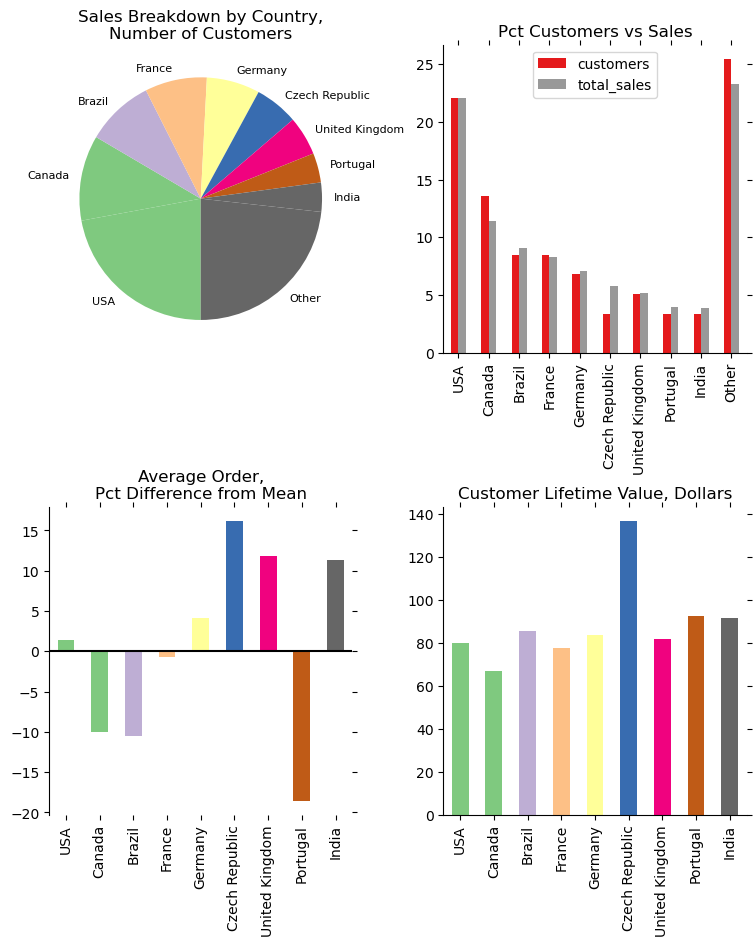

In [21]:
country_metrics = run_query(countries_and_others)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}

)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_per_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["avg_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

Because the amount of data from each of these countries is relatively low, we should not spend too much money on new marketing campaigns because the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.